<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DECam HiTS Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: May 8, 2024<br>
LSST Science Piplines version: w_2024_18<br>
Container Size: Medium<br>

# DM-42616: ApPipe on DECam HiTS with Preconvolution, March 2024

New DECam HiTS base run, compared with February 2023 base run.

* Uses `decam_rings_v1` skymap
* Templates from HiTS 2014 are in `/sdf/group/rubin/repo/main/u/elhoward/DM-38243/templates`
* Final processing of HiTS 2015 is in `u/elhoward/DM-42616/HiTS`
* Postgres schema is `elhoward_dm42616_hits_appipe`
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/group/rubin/u/elhoward/repo-main-logs/DM-42616`

For ApPipe.yaml:
```
inCollection: u/elhoward/DM-38243/templates,refcats/DM-39298,pretrained_models
dataQuery: "instrument='DECam' AND skymap='decam_rings_v1' AND detector NOT IN (2, 61) AND exposure>400000"
```

Notes: The exposure cuts are necessary to force each pipeline to use only the 2014 images (numbered in the 200000s) for template building, and to use only the 2015 images (numbered in the 400000s) as science images.

## Analysis Summary
Note that this comparison is based on two runs over a year apart.
* Significant decrease in `diaSources`, slight increase in good `diaSources`.
* Large decrease in `diaObjects`, slight increase in good `diaObjects`.
* `psFlux` scewed more positive.
* `totFlux` scewed more negative.
* Obvious decrease in edge flags.
* SNR spread has decreased significantly with an even sharper near-zero peak.

## Previous Runs 
-  [DM-37694: ApPipeWithFakes on DECam HiTS, February 2023](./DM-37694-AP-DECam-HiTS-Feb2023.ipynb)
-  [DM-35284: ApPipeWithFakes on DECam HiTS, November 2022](./DM-35284-AP-DECam-HiTS-Nov2022.ipynb) (Data has since been corrupted)
-  [DM-36024: ApPipeWithFakes on DECam HiTS, October 2022](./DM-36024-AP-DECam-HiTS-Oct2022.ipynb) 

## Table of Contents

1. [Imports, Helper Functions, and Loading](#section_1)
2. [DiaObject and DiaSources analysis](#section_2)
3. [Comparisons to previous processing run](#section_3)
4. [SNR distributions](#section_4)

## 1. <a id="section_1">Imports, Helper Functions, and Loading</a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import lsst.daf.butler as dafButler
from lsst.pipe.base import Instrument
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import apdb

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import functools
import operator
from IPython.display import Image, display

import lsst.afw.display as afwDisplay
import astropy.units as u

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

### Helper Functions

In [2]:
badFlagList=['base_PixelFlags_flag_bad',
             'base_PixelFlags_flag_suspect',
             'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_interpolated',
             'base_PixelFlags_flag_interpolatedCenter',
             'base_PixelFlags_flag_edge',
             ]

In [3]:
bandList = ['g']
colorList = ['C2']

In [4]:
def flagTables(sourceTable, objectTable, badFlagList, butler, instrument=None):
    """Apply flag filters to a DIA Source and a DIA Object table.
    
    Parameters
    ----------
    sourceTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Sources from an APDB.
    objectTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Objects from an APDB.
    badFlagList :  `list`
        Names of flags presumed to each indicate a DIA Source is garbage.
     instrument : `str`
        Default is 'DECam'
    Returns
    -------
    sourceTableFlags : `pandas.core.frame.DataFrame`
        Dataframe containing all DIA Sources from sourceTable
        with flags expanded.
    goodSrcFlags : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Sources from sourceTable
        with no bad flags, with all flags expanded.
    goodObjFlags : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from ObjectTable
        with no bad flags, with all flags expanded.
    """
    instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    # packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
    # dataId = packer.unpack(sourceTable.ccdVisitId)

    packer = Instrument.from_data_id(instrumentDataId).make_default_dimension_packer(data_id=instrumentDataId, is_exposure=False)
    dataId = packer.unpack(sourceTable.ccdVisitId.iloc[0])
    
    sourceTable['visit'] = dataId['visit']
    sourceTable['detector'] = dataId['detector']
    sourceTable['instrument'] = instrument
    
    config = TransformDiaSourceCatalogConfig()
    unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
    
    flagValues = unpacker.unpack(sourceTable['flags'], 'flags')
    flagTable = pd.DataFrame(flagValues, index=sourceTable.index)
    
    srcTableFlags = pd.merge(sourceTable, flagTable, left_index=True, right_index=True)
    badFlags = [srcTableFlags[flag] for flag in badFlagList]
    
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter
    
    goodSrcFlags = srcTableFlags.loc[noFlagFilter]
    
    goodObjIds = set(srcTableFlags.loc[noFlagFilter, 'diaObjectId'])
    goodObjFlags = objectTable.loc[objectTable['diaObjectId'].isin(goodObjIds)]
    
    return goodSrcFlags.reset_index(drop=True), goodObjFlags.reset_index(drop=True), flagTable, srcTableFlags

In [5]:
def spatial_flag_plot(df, df2, flagName1, flagName2=None, operator=None, plotFlagged=True, 
                      plotUnFlagged=True, title='', title2=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) | (df2[flagName2]))
            labelTrue2 = flagName1 + ' \nor ' + flagName2
            labelFalse2 = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) & (df2[flagName2]))
            labelTrue2 = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse2 = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
        
        flagFilter2 = (df2[flagName1])
        labelTrue2 = flagName1
        labelFalse2 = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    flagFilterInverse2 = ~flagFilter2
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'dec'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
        scatterFlagged = ax2.scatter(df2.loc[flagFilter2, 'ra'], df2.loc[flagFilter2, 'dec'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'dec'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        scatterUnflagged = ax2.scatter(df2.loc[flagFilterInverse2, 'ra'], df2.loc[flagFilterInverse2, 'dec'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        
    print(f'--{month} {year}--')
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title)
    
    print(f'--{month_old} {year_old}--')
    print('Flagged sources: {0}'.format(len(df2.loc[flagFilter2, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df2.loc[flagFilterInverse2, 'ra'])))
    ax2.set_xlabel('RA (deg)')
    ax2.set_ylabel('Dec (deg)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title(title2)
    
    xlim = (150.8, 149.8)
    ylim = (2.4, 3.1)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    plt.setp(ax2, xlim=xlim, ylim=ylim)
    plt.suptitle(f'Flagged vs Unflagged Sources ({fakeStatus})')

### Loading Data

In [6]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'DECam'
skymap = 'decam_rings_v1'

dbType='postgres'
dbName='lsst-devl'

fakeStatus = 'no fakes'

dmnum = '42616'
collections = f'u/elhoward/DM-{dmnum}/HiTS'
schema = f'elhoward_dm{dmnum}_hits_appipe'
month = 'March'
year = '2024'

dmnum_old = '37694'
collections_old = f'u/elhoward/DM-{dmnum_old}/hits2015'
schema_old = f'elhoward_dm{dmnum_old}_hits_appipe'
month_old = 'February'
year_old = '2023'

collectionsList = [collections,collections_old]

apdbQuery = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema)

In [7]:
with apdbQuery.connection as connection:
    srcTable = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "dec", "ccdVisitId", \
                                 "psfFlux" AS "psFlux", "psfFluxErr" AS "psFluxErr", \
                                 "scienceFlux" AS "totFlux", "scienceFluxErr" AS "totFluxErr", "snr", \
                                 "flags", "band" AS "filterName", "x", "y" \
                                 FROM "{}"."DiaSource";'.format(schema), connection)

In [8]:
with apdbQuery.connection as connection:
    objTable = pd.read_sql_query('SELECT "diaObjectId", "ra", "dec", "nDiaSources", "flags", \
                                 "g_psfFluxMean" AS "gPSFluxMean", "r_psfFluxMean" AS "rPSFluxMean", \
                                 "i_psfFluxMean" AS "iPSFluxMean", "z_psfFluxMean" AS "zPSFluxMean", \
                                 "y_psfFluxMean" AS "yPSFluxMean" \
                                 FROM "{}"."DiaObject" \
                                 WHERE "validityEnd" is NULL;'.format(schema), connection)

In [9]:
goodSrc, goodObj, flagTable, srcTableFlags = flagTables(srcTable, objTable, badFlagList, butler, instrument)

In [10]:
apdbQuery_old = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema_old)

In [11]:
with apdbQuery_old.connection as connection:
    srcTable_old = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "decl" as "dec", "ccdVisitId", \
                                     "flags", "filterName", "psFlux", "psFluxErr", \
                                     "totFlux", "totFluxErr", "snr", "x", "y" \
                                     FROM "{}"."DiaSource";'.format(schema_old), connection)

In [12]:
with apdbQuery_old.connection as connection:
    objTable_old = pd.read_sql_query('SELECT "diaObjectId", "ra", "decl" as "dec", "nDiaSources", "flags", \
                                     "gPSFluxMean", "rPSFluxMean", "iPSFluxMean", \
                                     "zPSFluxMean", "yPSFluxMean" \
                                     FROM "{}"."DiaObject" \
                                     WHERE "validityEnd" is NULL;'.format(schema_old), connection)

In [13]:
goodSrc_old, goodObj_old, flagTable_old, srcTableFlags_old = flagTables(srcTable_old, objTable_old, badFlagList, butler, instrument)

## 2. <a id="section_2">DIA object and source visual analysis</a>

In [14]:
bandList = ['g']
colorList = ['C2']
collection = collections

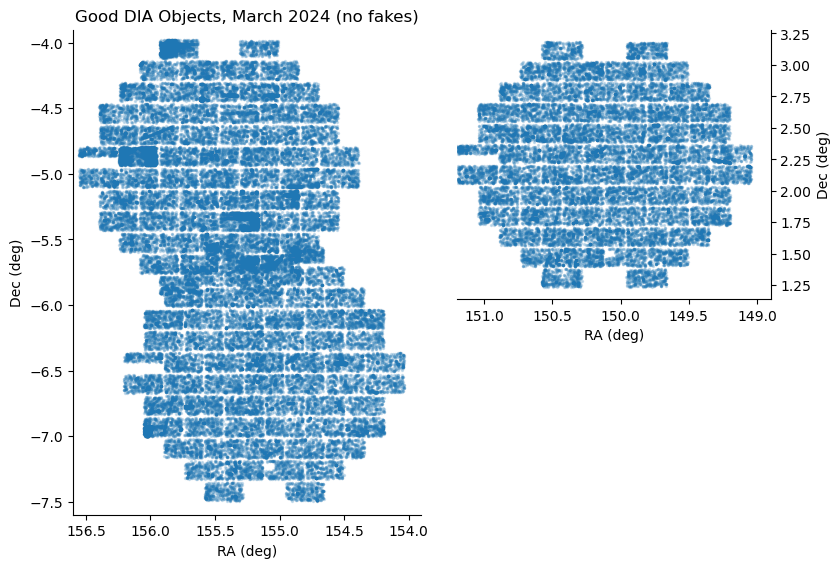

In [15]:
hitsPlot = plac.plotHitsSourcesOnSky(goodObj, title=f'Good DIA Objects, {month} {year} ({fakeStatus})')

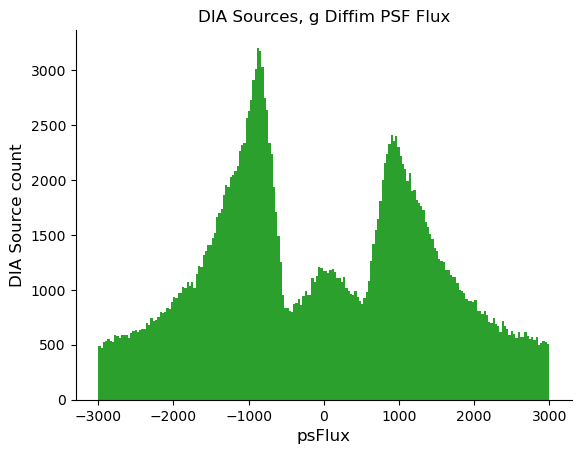

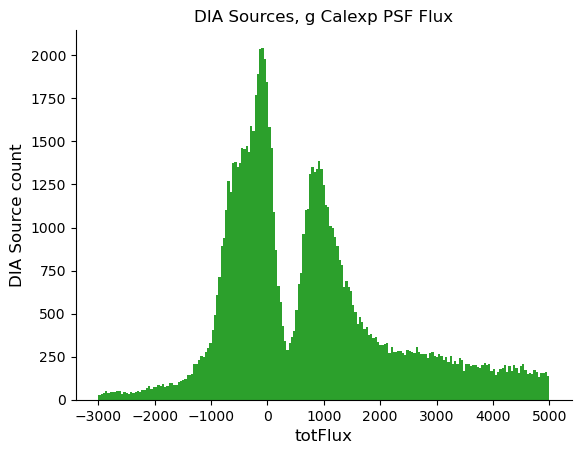

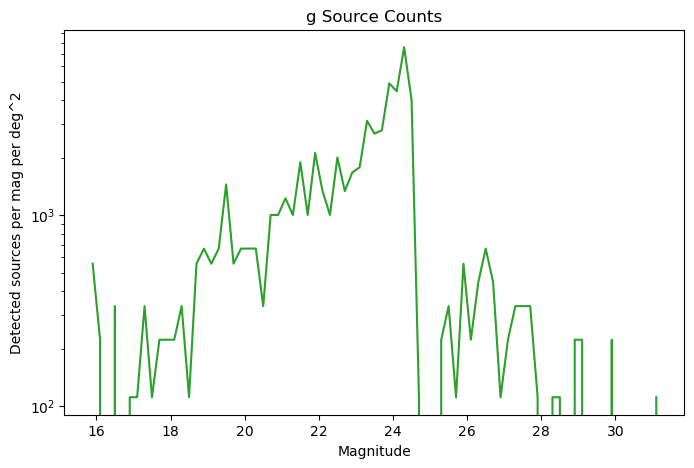

In [16]:
for band, color in zip(bandList, colorList):
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux', color1=color, binmin=-3e3, binmax=3e3)
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux', color1=color, binmin=-3e3, binmax=5e3)
    plac.source_magnitude_histogram(repo, goodSrc, band, 'DECam', collection)

## 3. <a id="section_3">Comparison to previous processing run</a>

Large increase in DIA objects and sources, moderate increase in good DIA objects and slight increase in good DIA sources. The shape of the psFlux and totFlux histograms changed, most noteably around zero and in the negatives. Noticeable increase in edge and suspect flags.

Text(0.5, 1.0, 'Comparing DIA Object and Source counts (no fakes)')

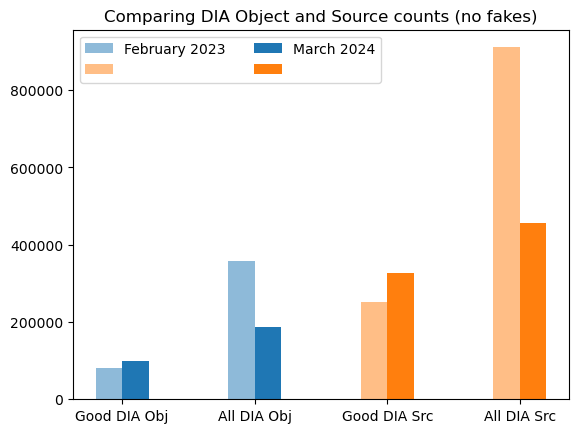

In [17]:
label1 = f'{month_old} {year_old}'
label2 = f'{month} {year}'

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Previous Run
ax.bar(xbar - width/2, [len(goodObj_old), len(objTable_old)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2 - width/2, [len(goodSrc_old), len(srcTable_old)],
       width, label=' ', color='C1', alpha=0.5)

# Current Run
ax.bar(xbar + width/2, [len(goodObj), len(objTable)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width/2, [len(goodSrc), len(srcTable)],
       width, label=' ', color='C1')

plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title(f'Comparing DIA Object and Source counts ({fakeStatus})')

Text(0.5, 0.98, 'Good DIA Objects (no fakes)')

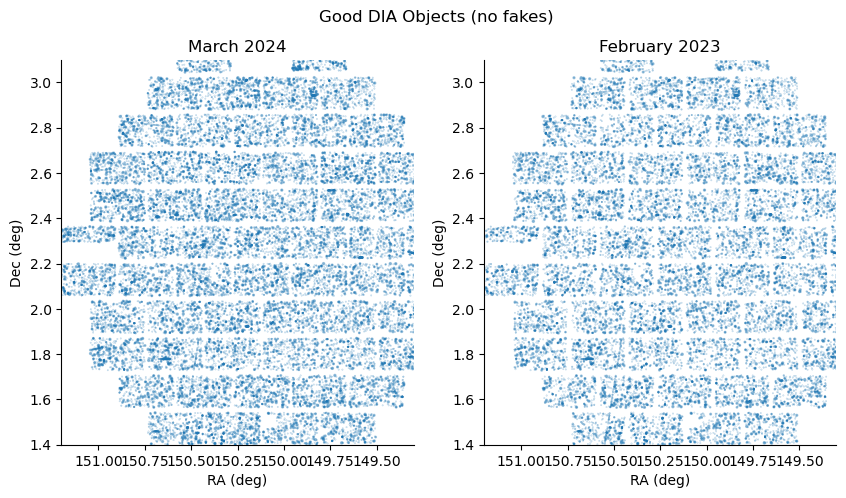

In [18]:
fig = plt.figure(figsize=(10,5))

cutoff = 0  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'dec'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'dec'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle(f'Good DIA Objects ({fakeStatus})')

Text(0.5, 0.98, 'DIA Objects composed of > 3 "Good" DIA Sources (no fakes)')

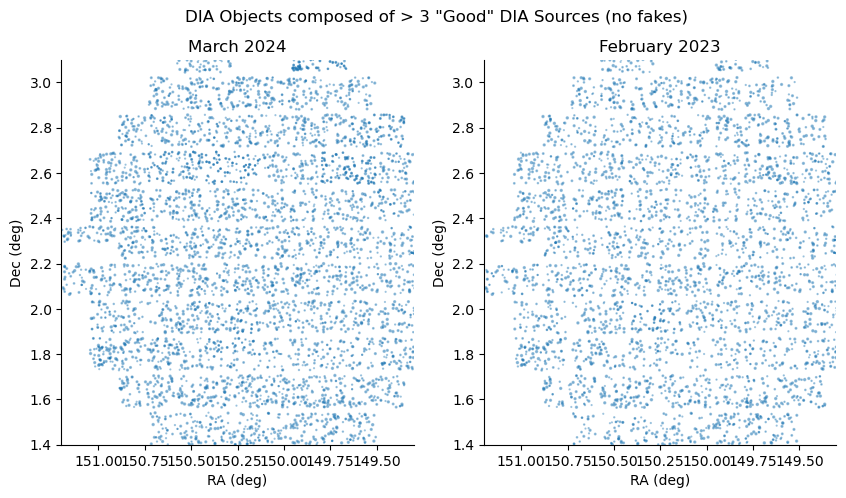

In [19]:
fig = plt.figure(figsize=(10,5))

cutoff = 3  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'dec'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'dec'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle(f'DIA Objects composed of > {cutoff} "Good" DIA Sources ({fakeStatus})')

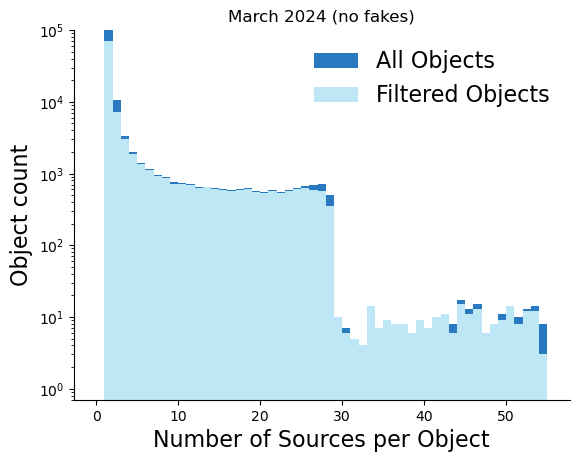

In [20]:
hist = plac.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year} ({fakeStatus})')

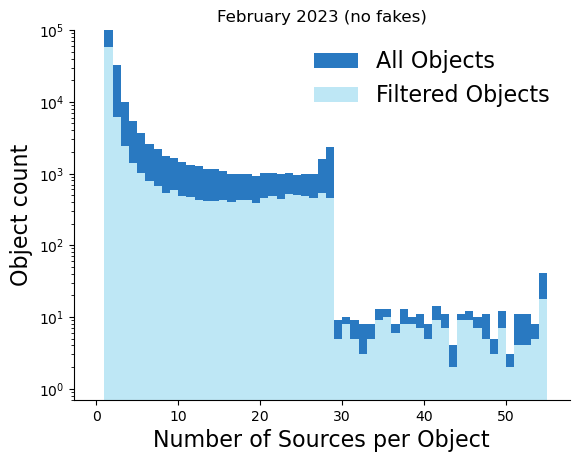

In [21]:
hist = plac.plotDiaObjectHistogram(objTable_old, goodObj_old, title=f'{month_old} {year_old} ({fakeStatus})')

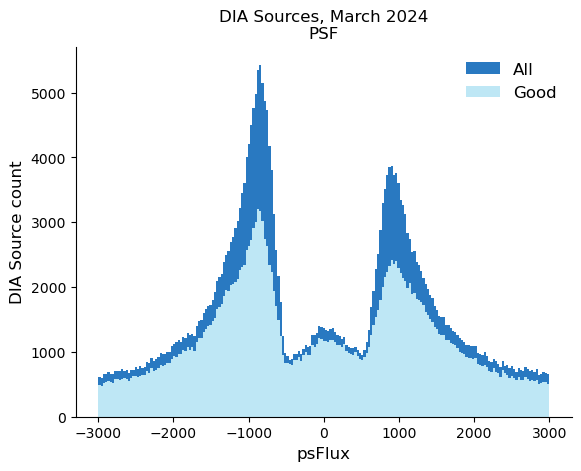

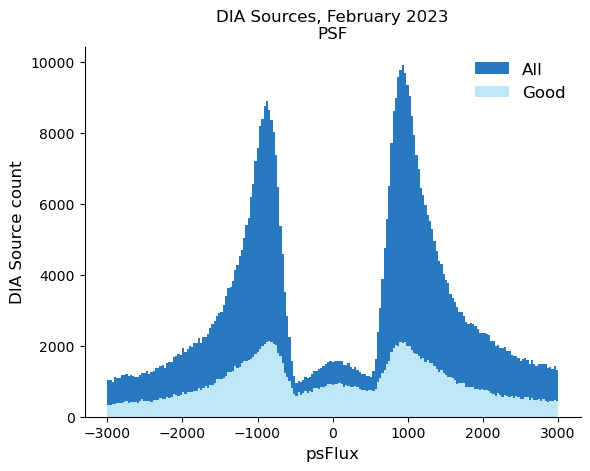

In [22]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nPSF')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nPSF')

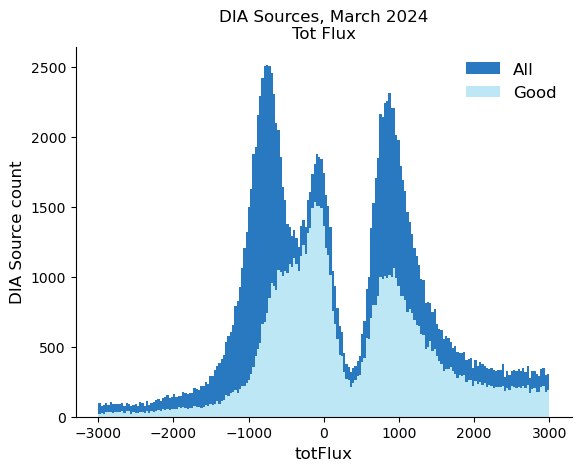

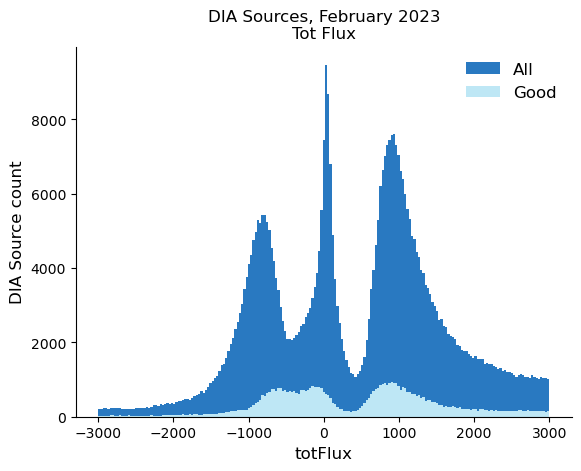

In [23]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nTot Flux')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nTot Flux')

--March 2024--
Flagged sources: 94690
Unflagged sources: 362749
--February 2023--
Flagged sources: 553126
Unflagged sources: 357925


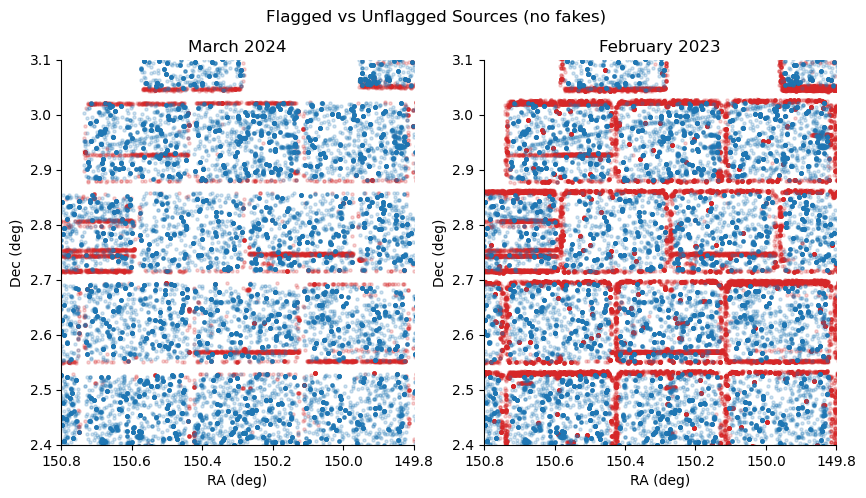

In [24]:
spatial_flag_plot(srcTableFlags, srcTableFlags_old, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_suspect', operator='or',
                  title=f'{month} {year}', title2=f'{month_old} {year_old}')

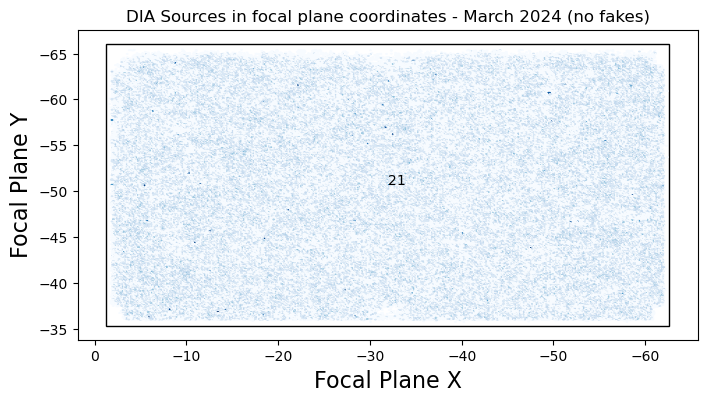

In [25]:
plac.plotDiaSourcesInFocalPlane(repo, goodSrc, title=f'- {month} {year} ({fakeStatus})', instrument='DECam',
                               collections=collections)

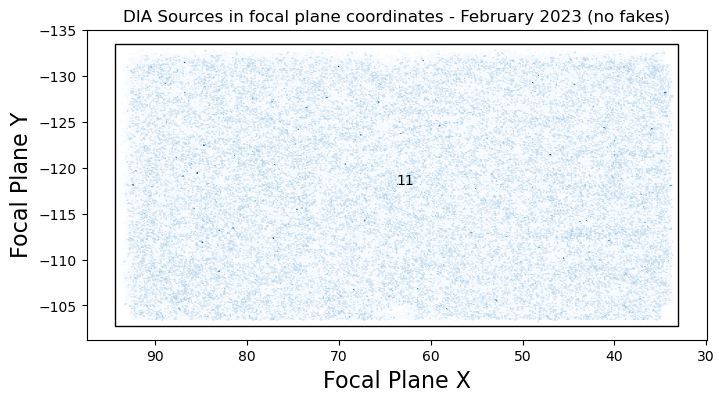

In [26]:
plac.plotDiaSourcesInFocalPlane(repo, goodSrc_old, title=f'- {month_old} {year_old} ({fakeStatus})', instrument='DECam',
                               collections=collections_old)

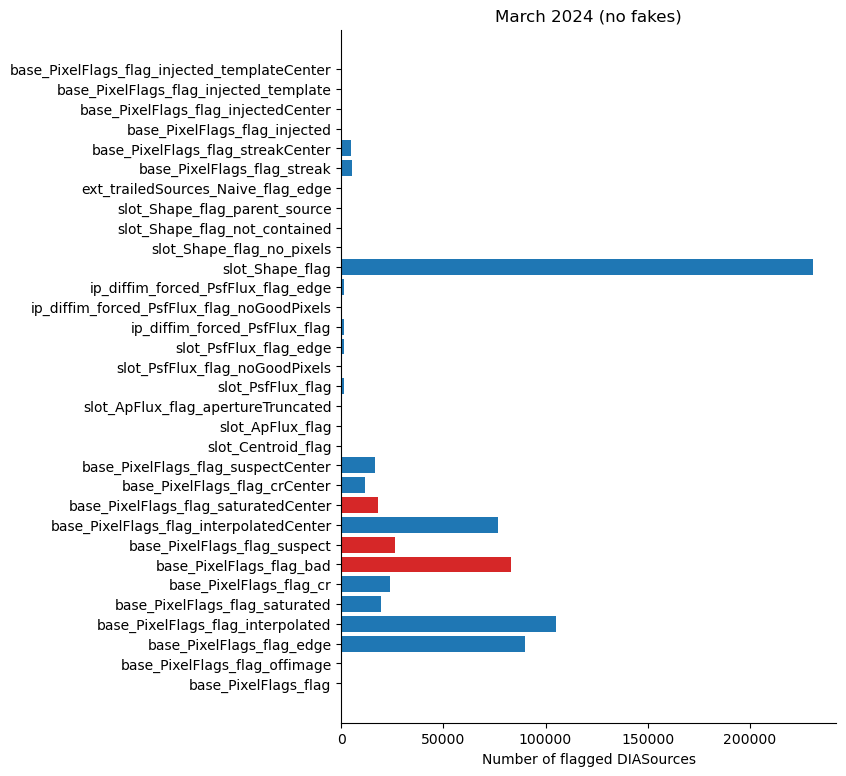

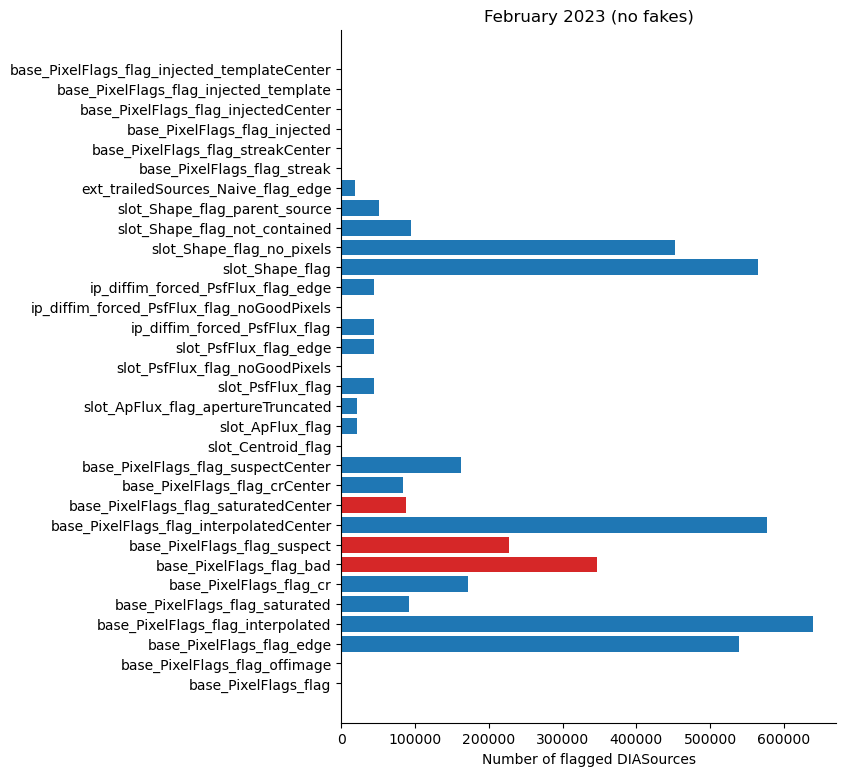

In [27]:
plac.plotFlagHist(srcTable, title=f'{month} {year} ({fakeStatus})')
plac.plotFlagHist(srcTable_old, title=f'{month_old} {year_old} ({fakeStatus})')

### By the Numbers

In [28]:
nObj = len(objTable)
nObj_old = len(objTable_old)

print(f"{month} {year}, Number of objects: ",nObj)
print(f"{month_old} {year_old}, Number of objects: ",nObj_old)

print("Diff: ", nObj-nObj_old)

March 2024, Number of objects:  187492
February 2023, Number of objects:  358102
Diff:  -170610


In [29]:
nGoodObj = len(goodObj)
nGoodObj_old = len(goodObj_old)

print(f"{month} {year}, Number of good objects: ",nGoodObj)
print(f"{month_old} {year_old}, Number of good objects: ",nGoodObj_old)

print("Diff: ", nGoodObj-nGoodObj_old)

March 2024, Number of good objects:  98071
February 2023, Number of good objects:  79749
Diff:  18322


In [30]:
nGoodSrc = len(goodSrc)
nGoodSrc_old = len(goodSrc_old)

print(f"{month} {year}, Number of good sources: ",nGoodSrc)
print(f"{month_old} {year_old}, Number of good sources: ",nGoodSrc_old)

print("Diff: ", nGoodSrc-nGoodSrc_old)

March 2024, Number of good sources:  328052
February 2023, Number of good sources:  251170
Diff:  76882


In [31]:
nSrc = len(srcTable)
nSrc_old = len(srcTable_old)

print(f"{month} {year}, Number of sources: ",nSrc)
print(f"{month_old} {year_old}, Number of sources: ",nSrc_old)

print("Diff: ", nSrc-nSrc_old)

March 2024, Number of sources:  457439
February 2023, Number of sources:  911051
Diff:  -453612


## 4. <a id="section_4">SNR distributions</a>

(0.0, 10000.0)

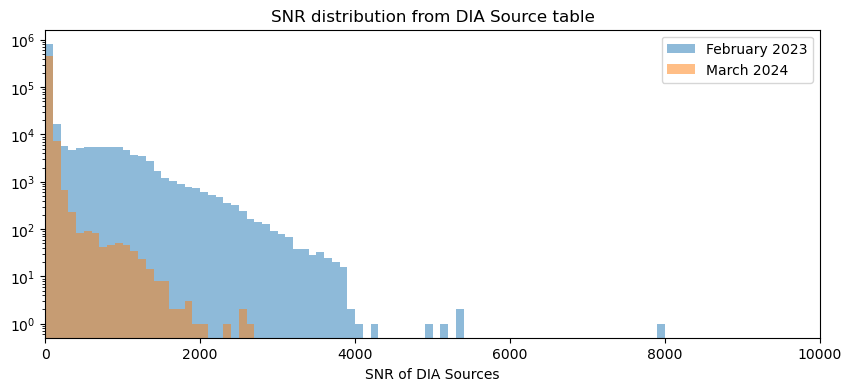

In [32]:
binwidth=100

newSNR = srcTable.snr
oldSNR = srcTable_old.snr

plt.figure(figsize=(10,4))
plt.yscale('log')
plt.hist(oldSNR, bins=range(0, int(max(oldSNR)) + binwidth, binwidth), alpha=0.5, label=f'{month_old} {year_old}')
plt.hist(newSNR, bins=range(0, int(max(newSNR)) + binwidth, binwidth), alpha=0.5, label=f'{month} {year}')
plt.legend()
plt.title(f'SNR distribution from DIA Source table')
plt.xlabel('SNR of DIA Sources')
plt.gca().set_xlim(0, 10000)